# Introduction to Natural Language Processing 01
# Lab 03

## Introduction

_The project is a continuation of what we started on the second lab. You will train a logistic regression classifier on manually extracted features._

We need to import plotting, data management, machine learning and mathematic librairies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset

import torch
from torch import nn

sns.set_theme()
%matplotlib inline

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Features

_For every given text, we want to generate a vector with the features seen in class._

_(6 points) Code the following features:_

- _1 if "no" appears in the document, 0 otherwise._
- _The count of first and second pronouns in the document._
- _1 if "!" is in the document, 0 otherwise._
- _Log(word count in the document)._
- _Number of words in the document which are in the positive lexicon._
- _Number of words in the document which are in the negative lexicon._
- _[Bonus] Add another feature of your choice._

In order to achieve this, we first need to apply some preprocessing over our data to ease the feature extraction.

In [2]:
from string import punctuation
import re

def preprocessing(data : str) -> str:
    """
    Preprocess the data by removing punctuation, converting to lowercase and removing extra spaces
    The function does not remove the "-" dash symbol

    For example : son-in-law ≠ son in law

    :param data: string data to preprocess 
    :return: preprocessed string data
    """
    data = data.replace("<br />", "")
    toremove = punctuation.replace("-", "").replace("!", "")
    translator = str.maketrans(toremove, ' ' * len(toremove))
    res = data.lower().translate(translator).strip()
    res = re.sub(r'\s+', ' ', res)
    return res

Then we need to have a dictionary that can give a "sentiment" value, VADER will do the trick.

In [3]:
def lexicon_dict(path : str = "vader_lexicon.txt") -> dict:
    """
    Open the vader_lexicon.txt file and construct the dictionary.
    Implementation is inspired by the one in the vaderSentiment package.
    
    :return: Dictionary containing the words in the lexicon as keys and their sentiment as values.
    """
    lex_dict = {}
    with open(path, encoding='utf-8') as file:
        content = file.read()

        for line in content.rstrip('\n').split('\n'):
            word, measure = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)

    return lex_dict


Now let's implement the features vector function, which takes a piece of text and returns it's feature vector. **We also added a bonus feature ("!" count)**.

In [4]:
def features_vector(text : str, use_bonus : bool, lex_dict : dict) -> np.ndarray:
    """
    Return the features vector of the text with each component representing the following features:
    - 1 if "no" appears in the document, 0 otherwise.
    - The count of first and second pronouns in the document.
    - 1 if "!" is in the document, 0 otherwise.
    - Log(word count in the document).
    - Number of words in the document which are in the positive lexicon.
    - Number of words in the document which are in the negative lexicon.

    Assuming that basic preprocessing has been done on the text (punctuation removed and lowercase).

    :param text: The text to extract the features from.
    :param dict: A sentiment analysis lexicon 
    :return: A numpy array of shape (6,) containing the features.
    """
    splitted_text = list(filter(lambda s : s != '', text.split()))

    no_present = int(f' no ' in f' {text} ') # Faster than splitting
    pronouns_count = sum([word in ['i', 'you'] for word in splitted_text])
    exclamation_present = int(f'!' in f' {text} ')
    log_word_count = np.log(len(splitted_text))

    # check every word appereance in the lexicon and get its sentiment value
    sentiment_array = np.vectorize(lambda x: lex_dict.get(x, 0.0))(text.split())
    positive_count = np.sum(sentiment_array >= 0.05)
    negative_count = np.sum(sentiment_array <= -0.05)
    
    if use_bonus: # Bonus feature
        bonus_exclamation_count = text.count("!")
        return np.array([
            no_present,
            pronouns_count,
            exclamation_present,
            log_word_count,
            positive_count,
            negative_count,
            bonus_exclamation_count])
    
    return np.array([
        no_present,
        pronouns_count,
        exclamation_present,
        log_word_count,
        positive_count,
        negative_count])

Let's test it on a piece of example text

In [5]:
text = "I loved this excellent movie"
text = preprocessing(text)

We get the following feature vector (bonus ignored)

In [6]:
features_vector(text, False, lexicon_dict())

array([0.        , 1.        , 0.        , 1.60943791, 2.        ,
       0.        ])

## Logistic regression classifier

We need to freeze the random seed to get this experiment to be deterministic.

In [7]:
RANDOM_SEED = 42
np.random.seed(seed=RANDOM_SEED) # Set the seed for reproducibility
torch.manual_seed(RANDOM_SEED)

_(3 points) Adapt the code by adding your feature extractor and train a classifier._

_For training, don't use the test set as validation. Instead, split the training set into a training and a validation set (use 10 to 20% of the training set as validation)._


Here is a function to get the preprocessed dataset

In [8]:
def get_processed_data(dataset_name : str, split : str) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]: 
    """
    Load a split from the hugging face dataset and preprocess it.
    
    :param dataset_name: Name of a hugging face dataset (e.g. "imdb")
    :param split: The split to load (e.g. "train" or "test")
    :return: A tuple containing the feature vectors and the labels as torch tensors.
    """
    
    # Load data with hugging face dataset
    train_data = load_dataset('imdb', split=split)
    train_data = pd.DataFrame(train_data)
   
    # Apply preprocessing
    train_data["text"].apply(preprocessing)

    lex_dict = lexicon_dict()

    # Transform to feature vector
    X = torch.tensor(np.vectorize(
        lambda text: features_vector(text, False, lex_dict), signature='()->(n)')(np.array(train_data["text"].tolist())),
         dtype=torch.float32)
    y = torch.tensor(train_data['label'].to_numpy(), dtype=torch.float32).reshape(-1, 1)

    return X, y

Next, let's save them into variables.

In [9]:
X_train, y_train = get_processed_data("imdb", "train")

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [10]:
X_test, y_test = get_processed_data("imdb", "test")

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
)

Here is the LogisticRegression class, inspired from the teacher's implentation, that has been adapted to our needs. It allows us to instantiate a model that can be manipulated easily.

In [12]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        # output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            # output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

We instantiate our model and choose it's loss function and optimizer, we use the same as the teacher's implementation on binary classification.

In [13]:
model = LogisticRegression(X_train.shape[1], 1)
criterion = nn.BCEWithLogitsLoss()
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

Now, let's define a train function, and trigger the training for 1000 epochs. The training function will output its loss each 100 epochs.

In [14]:
%time

n_epochs = 1000

def train(verbose=True):
    """
    Performs gradient descent using the specified optimizer
    and loss criterion.

    Args:
        verbose (bool, optional): If True, prints the training
        loss for every 100th epoch. Default is True.

    Returns:
        train_losses (list): A list of training losses for each epoch.
        test_losses (list): A list of validation losses for each epoch.
    """
    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(n_epochs):
        # Setting all gradients to zero.
        optimizer.zero_grad()

        # Sending the whole training set through the model.
        predictions = model(X_train)
        # Computing the loss.
        loss = criterion(predictions, y_train)
        train_losses.append(loss.item())
        if verbose and epoch % 100 == 0:
            print(loss)
        # Computing the gradients and gradient descent.
        loss.backward()
        optimizer.step()

        # When computing the validation loss, we do not want to update the weights.
        # torch.no_grad tells PyTorch to not save the necessary data used for
        # gradient descent.
        with torch.no_grad():
            predictions = model(X_valid)
            loss = criterion(predictions, y_valid)
            test_losses.append(loss)
    return train_losses, test_losses

# Keeping an eye on the losses
train_losses, test_losses = train()


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
tensor(1.2303, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6066, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6054, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6050, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6047, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6046, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6046, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6045, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


_(1 point) Evaluate your classifier in terms of accuracy for the training, validation, and test set._

We need to evaluate the trained model on each dataset, first let's view the training curves for the training and test losses.

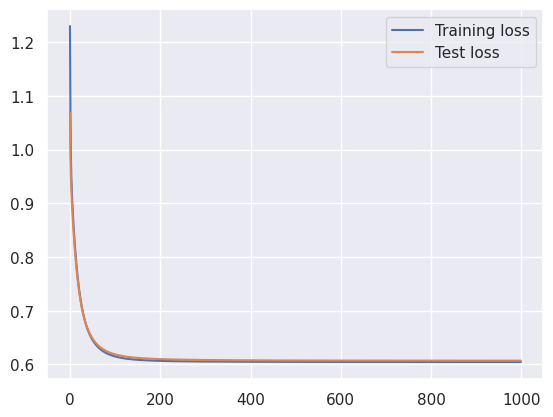

In [15]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

Besides, we implement a test function, which outputs the accuracy for the train, test and validation datasets, using the trained model. Next we trigger it.

In [34]:
def test():
    """
    Runs a test on train, valid and test datasets.
    """
    # Computing the accuracy for our 3 splits.
    with torch.no_grad():
        p_train = torch.sigmoid(model(X_train))
        p_train = np.round(p_train.numpy())
        training_accuracy = np.mean(p_train == y_train.numpy())
        p_valid = torch.sigmoid(model(X_valid))
        p_valid = np.round(p_valid.numpy())
        valid_accuracy = np.mean(p_valid == y_valid.numpy())
        p_test = torch.sigmoid(model(X_test))
        p_test = np.round(p_test.numpy())
        test_accuracy = np.mean(p_test == y_test.numpy())
    
    print(training_accuracy, valid_accuracy, test_accuracy)


test()

0.69235 0.6836 0.69532


The test accuracy, which is the most important, is drawing near 70% accuracy.

_(1 point) Look at the weights of your classifier. Which features seems to play most for both classes?_

Let's view the different model internal parameters.

In [17]:
for name, param in model.named_parameters():
    print(f"{name} : {param}")

classifier.0.weight : Parameter containing:
tensor([[-0.0279, -0.0162, -0.0124, -0.0358,  0.1257, -0.1584]],
       requires_grad=True)
classifier.0.bias : Parameter containing:
tensor([-0.0073], requires_grad=True)


Here, we implement a fancy bar plot displaying what are the most prominent weights.

In [18]:
def plot_model_parameters(model : LogisticRegression) -> None:
    """
    Plots the features importance of features used in the Logistic Regression model
    
    :param model: Logistic Regression object used to train the model
    :return: None (A plot will be displayed)
    """

    Y = []
    for param in model.parameters():
        for weight in param:
            Y.append(weight.detach().numpy())
            break
    Y = Y[0]
    X = list(range(len(Y)))

    fig, ax = plt.subplots()

    plt.xlabel("Features")
    plt.ylabel("Weights")
    plt.title("Feature Importance")
    ax.set_xticks(np.arange(6), labels=["no_present", "exclamation_present", "log_word_count", "sentiment_array", "positive_count", "negative_count"])
    plt.xticks(rotation=45)
    plt.bar(X, Y)
    plt.show()

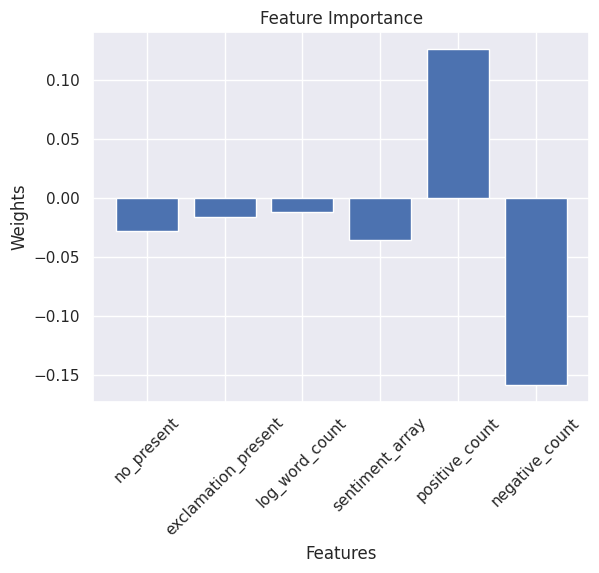

In [19]:
plot_model_parameters(model)

As we can see, the greatest weights are both word counting features. Positive and negative word count. They affect both classes.

_[Bonus] The parameter weight_decay of the SGD optimizer corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights._

We will iterate over [0.0, 1.0] - 10 times to check the accuracy and model weight evolution.

In [20]:
for i in range(0, 10 + 1):
    model = LogisticRegression(X_train.shape[1], 1)
    criterion = nn.BCEWithLogitsLoss() # Binary cross entropy
    # Stochastic gradient descent

    weight_decay = i / 10.0

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)
    train(False)
    print(f"For weight_decay={weight_decay} :")
    for param in model.parameters():
        for weight in param:
            print(weight.detach().numpy())
            break
    test()
    

For weight_decay=0.0 :
[ 0.04256586 -0.02322111 -0.25179562 -0.03805368  0.15725334 -0.19587044]
-0.014955189
0.3845 0.3806 0.38612
For weight_decay=0.1 :
[-0.02648991 -0.02503066  0.041814   -0.03644374  0.14796579 -0.1852033 ]
-0.074485116
0.39605 0.3924 0.40208
For weight_decay=0.2 :
[-0.05835649 -0.02157012  0.00271276 -0.0398839   0.14153051 -0.17614889]
-0.027763242
0.40545 0.4066 0.4094
For weight_decay=0.3 :
[-0.04089214 -0.01939373 -0.00495326 -0.04096391  0.1357776  -0.16968322]
-0.008012374
0.41405 0.414 0.41816
For weight_decay=0.4 :
[-0.03152217 -0.01763468 -0.01037819 -0.03815006  0.13047422 -0.1638469 ]
-0.0076611065
0.42185 0.4206 0.42696
For weight_decay=0.5 :
[-0.02847102 -0.01622686 -0.01089516 -0.03655519  0.12572795 -0.1583502 ]
-0.00399264
0.4279 0.4286 0.4332
For weight_decay=0.6 :
[-0.02584398 -0.015063   -0.01050031 -0.03427787  0.12138502 -0.15335777]
-0.0048996666
0.43265 0.4342 0.43904
For weight_decay=0.7 :
[-0.02249279 -0.01408009 -0.00893397 -0.03246563  

Increasing weight decay lead to smaller model weights and it doesn't affect accuracy.

_(1 point) Take two wrongly classified samples in the test set and try explaining why the model was wrong._

We need to use a new and fresh model and train it.

In [21]:
model = LogisticRegression(X_train.shape[1], 1)
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy
# Stochastic gradient descent

weight_decay = i / 10.0

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1.0)
train(False); # To avoid print

Now that its trained we can pick two wrongly classified examples and analyse them.

In [22]:
test_set = load_dataset('imdb', split="test")
test_set = pd.DataFrame(test_set)

predicted = np.round(model(X_test).detach().numpy()[:,0]).astype(int)

test_set["predicted"] = predicted
wrongs = test_set[test_set["label"] != test_set["predicted"]].head(2)

for index, data in wrongs.iterrows():
    text, label, predicted = data
    print(features_vector(text, False, lexicon_dict()))
    print(text, label, predicted)

Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
[ 0.          4.          0.          5.37989735 15.         15.        ]
Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from t

**First error : predicted 1 instead of 0**

[0., 3., 1., 4.8978398, 13., 1.]

_First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!_

**The model doesn't understand the context, the reviewer is a hard Van Damne fan, he compares the movie from other Van Damne movies, but relative to any movie he considers it a bad movie.**

**Second error : predicted 1 instead of 0**

[0., 0., 0., 5.24702407, 11., 2.]

_Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film at all, but more or less, I have a problem with the script. Also, I understand that this film was made in the 1930's and people were looking to escape reality, but the script made Ann Sothern's character look weak. She kept going back and forth between suitors and I felt as though she should have stayed with Paul Kelly's character in the end. He truly did care about her and her family and would have done anything for her and he did by giving her up in the end to fickle Neil Hamilton who in my opinion was only out for a good time. Paul Kelly's character, although a workaholic was a man of integrity and truly loved Kitty (Ann Sothern) as opposed to Neil Hamilton, while he did like her a lot, I didn't see the depth of love that he had for her character. The production values were great, but the script could have used a little work._

**Same here, the model doesn't understand the context, the reviewer explains the plot and critizes it. However he tries to still recommend the other aspects of the film by using the words "decent", "great", but overall disliked the movie.**

_[Bonus] Train logistic regression classifier using the scikit-learn implementation. How does it compare with the PyTorch version?_

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_reg = LogisticRegression()

In [24]:
logistic_reg.fit(X_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [25]:
preds = logistic_reg.predict(X_valid)

In [26]:
accuracy_score(y_valid, preds)

0.6816

The accuracy 0.68 is the same than with the torch Logistic Regression compared with a really consise code, thanks to the sklearn's API.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=872d72c8-1d54-4f60-8556-02f9978ad2c8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>